In [1]:
!pip install split-folders

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
from torchsummary import summary
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

In [3]:
from google.colab import drive

#Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = "/content/drive/MyDrive/PetImages"
files = os.listdir(folder_path)

# Display files
for file in files:
    print(file)


Cat
Dog


In [5]:
data_dir='/content/drive/MyDrive/PetImages'
data_dir=pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output="pets", seed=41, ratio=(.8,.2))

Copying files: 25012 files [14:18, 29.14 files/s] 


In [6]:
data_dir='/content/pets'
data_dir=pathlib.Path(data_dir)

In [7]:
data_dir

PosixPath('/content/pets')

In [8]:
transform=transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [9]:
# Custom ImageFolder to skip missing/corrupt images
class FixedImageFolder(ImageFolder):
    def __getitem__(self, index):
        while True:
            try:
                return super(FixedImageFolder, self).__getitem__(index)
            except (FileNotFoundError, Image.UnidentifiedImageError, OSError, RuntimeError):
                print(f"Skipping missing/corrupt image: {self.imgs[index][0]}")
                index = (index + 1) % len(self.imgs)

# Load dataset
train_set = FixedImageFolder(data_dir.joinpath('train'), transform=transform)
val_set = FixedImageFolder(data_dir.joinpath('val'), transform=transform)

# Remove missing image references before creating DataLoader
train_set.samples = [(path, class_index) for path, class_index in train_set.samples if os.path.exists(path)]
val_set.samples = [(path, class_index) for path, class_index in val_set.samples if os.path.exists(path)]


In [10]:
print(val_set)

Dataset FixedImageFolder
    Number of datapoints: 5004
    Root location: /content/pets/val
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [11]:
print(train_set)

Dataset FixedImageFolder
    Number of datapoints: 20006
    Root location: /content/pets/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


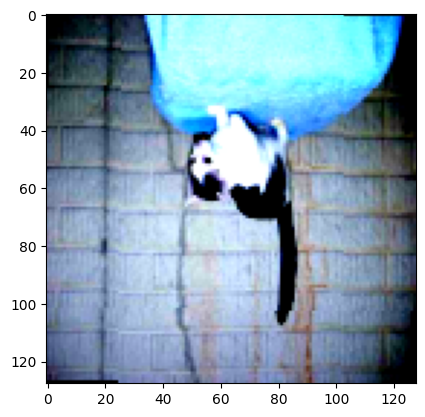

In [12]:
img,label=train_set[100]
plt.imshow(img.permute(1,2,0))

In [13]:
batch_size=100
train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_loader=torch.utils.data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)

In [14]:
next(iter(train_loader))[0].shape

torch.Size([100, 3, 128, 128])

In [15]:
next(iter(val_loader))[0].shape

torch.Size([100, 3, 128, 128])

In [16]:
class CNNModel(nn.Module):
  def _get_flattened_size(self):
      """Pass a dummy tensor through the conv layers to calculate the flattened size."""
      dummy_input = torch.randn(1, 3, 128, 128)  # (batch_size, channels, height, width)
      out = self.maxpool1(self.leaky_relu(self.conv1(dummy_input)))
      out = self.maxpool2(self.leaky_relu(self.conv2(out)))
      out = self.maxpool3(self.leaky_relu(self.conv3(out)))
      out = self.maxpool4(self.leaky_relu(self.conv4(out)))
      return out.view(1, -1).size(1)  # Compute flattened size dynamically

  def __init__(self):
    super(CNNModel,self).__init__()

    #Conv1
    self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=1)    #128-5+1=124

    #Maxpool 1
    self.maxpool1=nn.MaxPool2d(kernel_size=2)   #124/2 = 62

    #Conv2
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=1)   #62-5+1= 58

    #Maxpool 2
    self.maxpool2=nn.MaxPool2d(kernel_size=2)   #58/2 = 29

    #Conv3
    self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=1)   #29-5+1= 25

    #Maxpool 3
    self.maxpool3=nn.MaxPool2d(kernel_size=2)   #25/2 = 12

    #Conv4
    self.conv4=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,stride=1,padding=1)    #12-5+1= 8

    #Maxpool 4
    self.maxpool4=nn.MaxPool2d(kernel_size=2)   #8/2= 4

    #Activation Function
    self.leaky_relu=nn.LeakyReLU()

    #Automatically determine the flattened size
    self.flattened_size = self._get_flattened_size()

    #Fully connected alyer 1
    self.fc1=nn.Linear(self.flattened_size,1024)

    #Fully connected alyer 2
    self.fc2=nn.Linear(1024,2)



  def forward(self,x):
    #layer 1
    out=self.leaky_relu(self.conv1(x))
    out=self.maxpool1(out)

    #layer 2
    out=self.leaky_relu(self.conv2(out))
    out=self.maxpool2(out)

    #layer 3
    out=self.leaky_relu(self.conv3(out))
    out=self.maxpool3(out)

    #layer 4
    out=self.leaky_relu(self.conv4(out))
    out=self.maxpool4(out)

    #Flatten

    out=out.view(out.size(0), -1)

    #Linear Function

    out=self.leaky_relu(self.fc1(out))
    out=self.fc2(out)

    return out


In [18]:
#Training CNN
num_epochs=10
model=CNNModel()
error=nn.CrossEntropyLoss()
lr=0.001
optimizer=optim.Adam(model.parameters(),lr=lr)
scheduler=ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=5)

In [19]:
def check_images(directory):
    for foldername, _, filenames in os.walk(directory):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            try:
                img = Image.open(file_path)  # Try opening the image
                img.verify()  # Verify if the image is valid
            except (Image.UnidentifiedImageError, OSError, RuntimeError):  # ✅ Corrected here
                print(f"Corrupt image found and removed: {file_path}")
                os.remove(file_path)  # Delete bad image

# Run on training & validation sets
check_images('/content/pets/train')
check_images('/content/pets/val')


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupt image found and removed: /content/pets/train/Dog/11702.jpg
Corrupt image found and removed: /content/pets/train/Dog/Thumbs.db
Corrupt image found and removed: /content/pets/train/Cat/666.jpg
Corrupt image found and removed: /content/pets/train/Cat/Thumbs.db


In [22]:
train_loss_list=[]
val_loss_list=[]
accuracy_list=[]

for epoch in range(num_epochs):
  train_loss=0.0
  val_loss=0.0
  accuracy=0.0
  for i,(images,labels) in enumerate(train_loader):
    outputs=model(images)
    loss=error(outputs,labels)
    optimizer.zero_grad()
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("loss in iteration: ",i,": ",loss.item())
  total=0
  correct=0
  for images,labels in val_loader:
    outputs=model(images)
    v_loss=error(outputs,labels)
    val_loss+=v_loss.item()
    predicted=torch.max(outputs.data,1)[1]

    total+=labels.size(0)
    correct+=(predicted==labels).sum()

  scheduler.step(val_loss/len(val_loader))
  accuracy=100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)

  print("Epoch:{} Loss:{} Accuracy:{}%".format(epoch+1,train_loss/len(train_loader),accuracy))

loss in iteration:  0 :  0.6960029602050781
loss in iteration:  1 :  1.2630599737167358
loss in iteration:  2 :  0.6905670166015625
loss in iteration:  3 :  0.700040340423584
loss in iteration:  4 :  0.6897043585777283
loss in iteration:  5 :  0.7035001516342163
loss in iteration:  6 :  0.6896752119064331
loss in iteration:  7 :  0.6970891356468201
loss in iteration:  8 :  0.6913283467292786
loss in iteration:  9 :  0.6787383556365967
loss in iteration:  10 :  0.7283598184585571
loss in iteration:  11 :  0.6932744383811951
loss in iteration:  12 :  0.6915609836578369
loss in iteration:  13 :  0.6901094317436218
loss in iteration:  14 :  0.6921176314353943
loss in iteration:  15 :  0.6889610290527344
loss in iteration:  16 :  0.6929417252540588
loss in iteration:  17 :  0.6878370046615601
loss in iteration:  18 :  0.6982824802398682
loss in iteration:  19 :  0.6863296627998352
loss in iteration:  20 :  0.6938230991363525
loss in iteration:  21 :  0.6861830949783325
loss in iteration:  2

In [23]:
train_loss_list

[0.6646032508332931,
 0.5847708523570009,
 0.5421174887697495,
 0.5107034052634121,
 0.4931179946334801,
 0.4750609816380994,
 0.44483517473609885,
 0.43240709491630097,
 0.4178722091575167,
 0.39716733539875465]

In [24]:
val_loss_list

[0.6365172582514146,
 0.5373165478893355,
 0.5532855666151234,
 0.6160692017452389,
 0.4774964592036079,
 0.4573928900793487,
 0.4651431114065881,
 0.45709282802600487,
 0.4145245904139444,
 0.384569677067738]

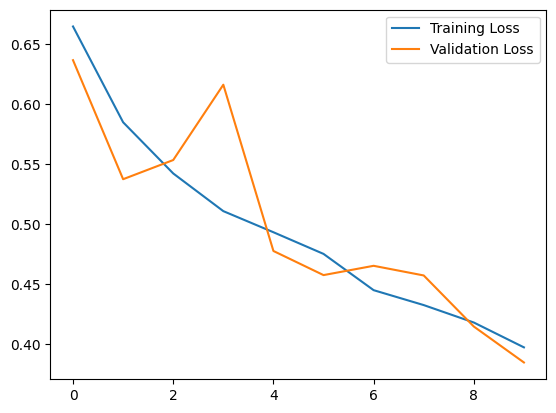

In [25]:
plt.plot(range(num_epochs),train_loss_list,label="Training Loss")
plt.plot(range(num_epochs),val_loss_list,label="Validation Loss")
plt.legend()
plt.show()

In [26]:
accuracy_list

[tensor(64.3285),
 tensor(72.9417),
 tensor(71.8225),
 tensor(69.5843),
 tensor(77.6579),
 tensor(78.0376),
 tensor(77.4181),
 tensor(78.8969),
 tensor(80.2158),
 tensor(81.8545)]

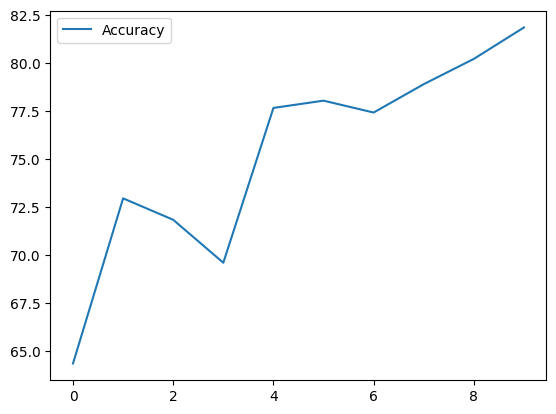

In [27]:
plt.plot(range(num_epochs),accuracy_list,label="Accuracy")
plt.legend()
plt.show()

0


Text(0.5, 1.0, '0')

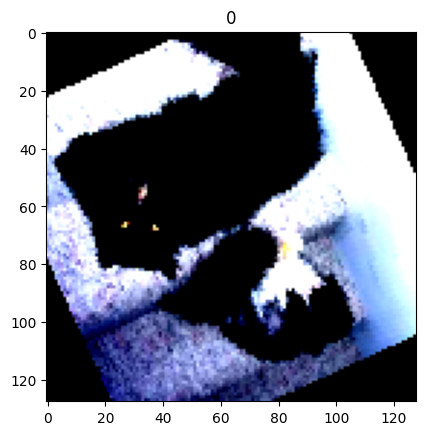

In [59]:
img,label=train_set[1000]
plt.imshow(img.permute(1,2,0))
print(label)
plt.title(label)

Image found at index: 2503


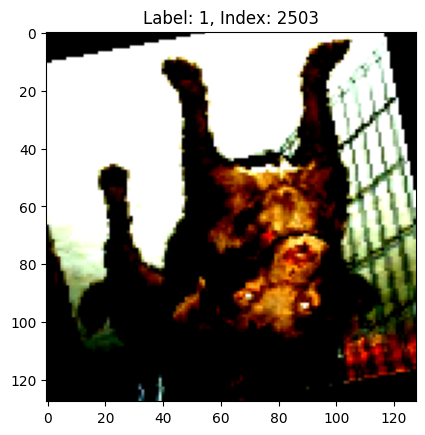

In [60]:
# Loop through the validation dataset with index to find an image with label 1
for idx, (img, label) in enumerate(val_set):
    if label == 1:  # Check if label is 1
        print(f"Image found at index: {idx}")  # Print the index
        plt.imshow(img.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.title(f"Label: {label}, Index: {idx}")
        plt.show()
        break  # Stop after finding the first image


1


Text(0.5, 1.0, '1')

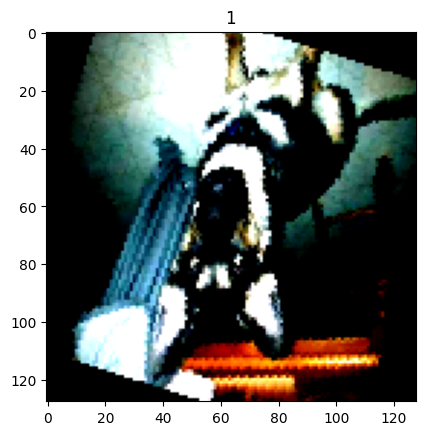

In [65]:
img,label=val_set[2506]
plt.imshow(img.permute(1,2,0))
print(label)
plt.title(label)

In [66]:
image=img.unsqueeze(0)

with torch.no_grad():
  output=model(image)
_,pred=torch.max(output,1)
print("Predicted output: ",pred.item())
# Check if prediction is correct
if label == pred.item():
    print("✅ Model predicted correctly!")
else:
    print("❌ Model predicted incorrectly.")

Predicted output:  1
✅ Model predicted correctly!


0


Text(0.5, 1.0, '0')

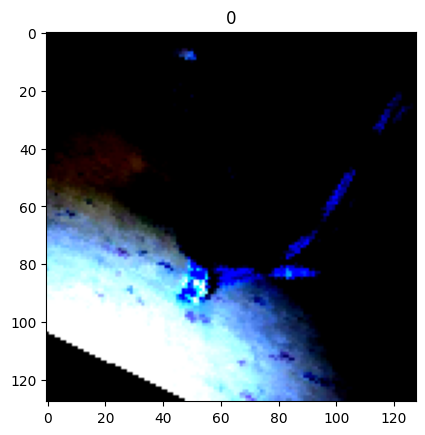

In [67]:
img,label=train_set[1540]
plt.imshow(img.permute(1,2,0))
print(label)
plt.title(label)

In [68]:
image=img.unsqueeze(0)

with torch.no_grad():
  output=model(image)
_,pred=torch.max(output,1)
print("Predicted output: ",pred.item())

# Check if prediction is correct
if label == pred.item():
    print("✅ Model predicted correctly!")
else:
    print("❌ Model predicted incorrectly.")

Predicted output:  1
❌ Model predicted incorrectly.
